# Neural Network Analysis

# 1. Prepare data

In [1]:
#basics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, mean_squared_error, recall_score

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils 
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout

plt.rcParams['font.size'] = 17

2022-12-21 11:35:17.142939: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Columns to be considered in the dataset
columns = ["LB", "AC", "FM", "UC", "DL", "DP", 
           "ASTV", "MSTV", "ALTV", "MLTV", "Width", "Min", 
           "Max", "Nmax", "Nzeros", "Mode", "Mean", "Median", "Variance", "Tendency"]

path = "../data/"

## Clean data

In [3]:
filename = "prep_data.csv"

df = pd.read_csv(path+filename)
df = df.reindex(np.random.permutation(df.index))

#Prepare X and y
X = df[columns]
y = df["NSP"]

#One-hot enconding of target values 
y_cat = utils.to_categorical(y-1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, train_size=0.8,random_state=45)

## Real data

In [4]:
filename = "CTG.xls"

df_raw = pd.read_excel(path+filename, sheet_name = "Data",header=1)
df_raw = df_raw.reindex(np.random.permutation(df_raw.index))

#Prepare X and y
X_raw = df_raw[columns]
y_raw = df_raw["NSP"]

#One-hot enconding of target values 
y_cat_raw = utils.to_categorical(y_raw-1)

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw, y_cat_raw, train_size=0.8,random_state=45)

# 2. Neural Network 

We define a `evaluate()` helper function to help us evaluate the different models.

In [5]:
def evaluate(y_pred, y_test, model_trace):
    
    # Apply argmax
    y_pred = np.argmax(y_pred,axis=1)
    y_compare = np.argmax(y_test,axis=1)
    
    print("Accuracy: %.2f"%accuracy_score(y_pred,y_compare))
    print("Recall: %.2f"%recall_score(y_pred,y_compare,average="macro"))

    cm = confusion_matrix(y_compare, y_pred, normalize="all")

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["1","2","3"])
    disp.plot()
    
    
    # Plot the loss function
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.plot(np.sqrt(model_trace.history['loss']), 'r', label='train')
    ax.plot(np.sqrt(model_trace.history['val_loss']), 'b' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=10)
    ax.set_ylabel(r'Loss', fontsize=10)
    ax.legend()
    ax.tick_params(labelsize=10)

    
    # Plot the accuracy
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.plot(np.sqrt(model_trace.history['accuracy']), 'r', label='train')
    ax.plot(np.sqrt(model_trace.history['val_accuracy']), 'b' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=10)
    ax.set_ylabel(r'Accuracy', fontsize=10)
    ax.legend()
    ax.tick_params(labelsize=10)

# 3. Change activation function

In this part, we evaluate the sigmoid and ReLu functions to see how they affect the model's performance.

## 3.1. HL(15 nodes, sigmoid)

In [6]:
model = Sequential()
model.add(Dense(15, input_dim=X.shape[1], activation='sigmoid')) # Hidden 1
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                315       
                                                                 
 dense_1 (Dense)             (None, 3)                 48        
                                                                 
Total params: 363
Trainable params: 363
Non-trainable params: 0
_________________________________________________________________


2022-12-21 11:35:28.340808: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


31/31 [==============================] - 0s 819us/step
Accuracy: 0.91
Recall: 0.91


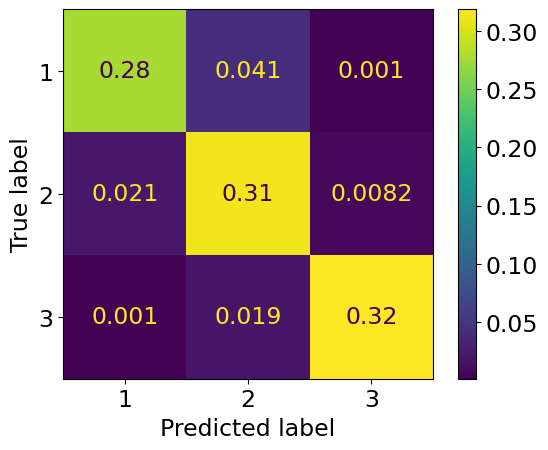

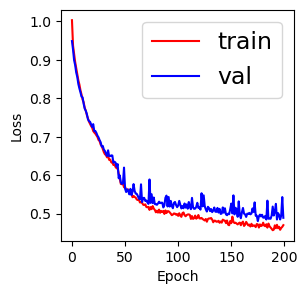

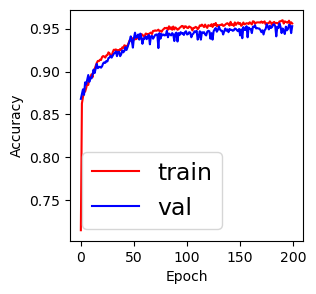

In [7]:
model_trace = model.fit(X_train,y_train,verbose=0,epochs=200, validation_data=(X_test, y_test))
y_pred = model.predict(X_test)
evaluate(y_pred, y_test, model_trace)

## 3.2. HL(15 nodes, ReLu)

In [8]:
model = Sequential()
model.add(Dense(15, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 15)                315       
                                                                 
 dense_3 (Dense)             (None, 3)                 48        
                                                                 
Total params: 363
Trainable params: 363
Non-trainable params: 0
_________________________________________________________________


31/31 [==============================] - 0s 1ms/step
Accuracy: 0.89
Recall: 0.90


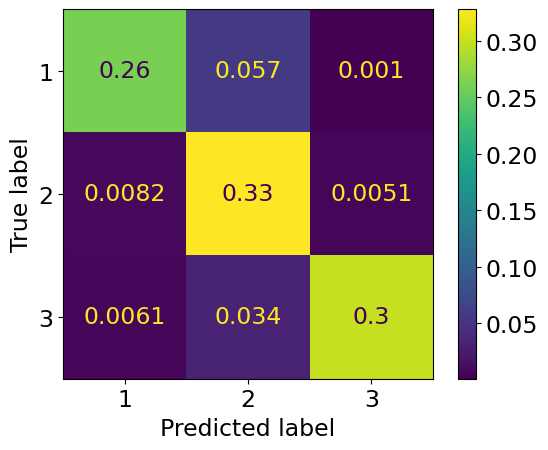

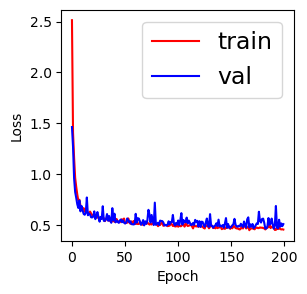

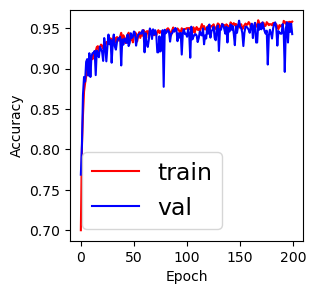

In [9]:
model_trace = model.fit(X_train,y_train,verbose=0,epochs=200,  validation_data=(X_test, y_test))
y_pred = model.predict(X_test)
evaluate(y_pred, y_test, model_trace)

 # 4. Change nodes in hidden layer

In this part, we test different number of hidden nodes to see how they affect the model's performance.

## 4.1. HL(30 nodes, sigmoid, epochs=200)

In [10]:
model = Sequential()
model.add(Dense(30, input_dim=X.shape[1], activation='sigmoid')) # Hidden 1
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 30)                630       
                                                                 
 dense_5 (Dense)             (None, 3)                 93        
                                                                 
Total params: 723
Trainable params: 723
Non-trainable params: 0
_________________________________________________________________


31/31 [==============================] - 0s 895us/step
Accuracy: 0.91
Recall: 0.92


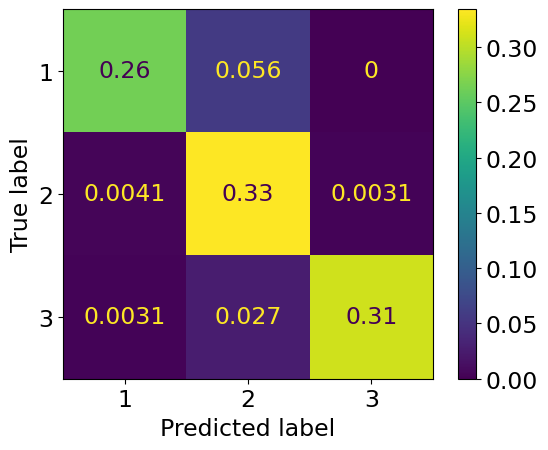

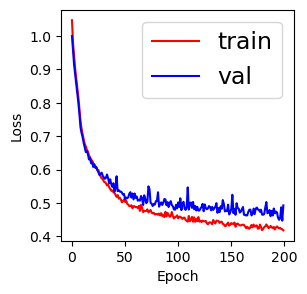

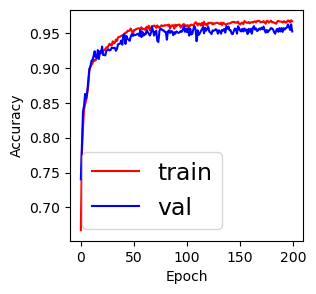

In [11]:
model_trace = model.fit(X_train,y_train,verbose=0,epochs=200, validation_data=(X_test, y_test))
y_pred = model.predict(X_test)
evaluate(y_pred, y_test, model_trace)

## 4.2. HL(30 nodes, ReLu, epochs=100)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 30)                630       
                                                                 
 dense_7 (Dense)             (None, 3)                 93        
                                                                 
Total params: 723
Trainable params: 723
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 986us/step
Accuracy: 0.89
Recall: 0.89


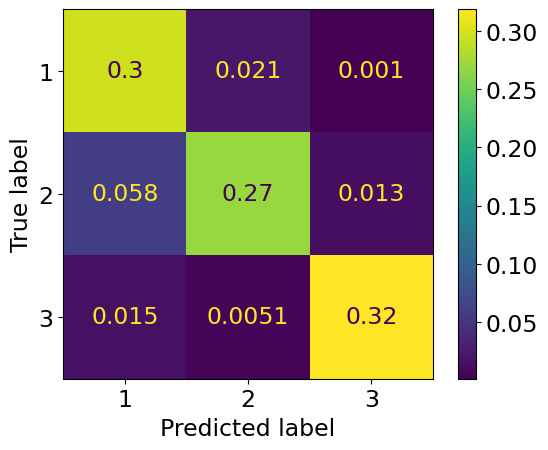

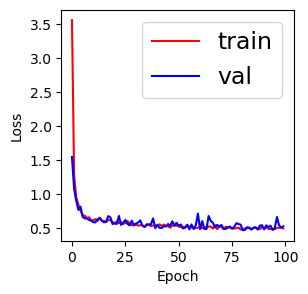

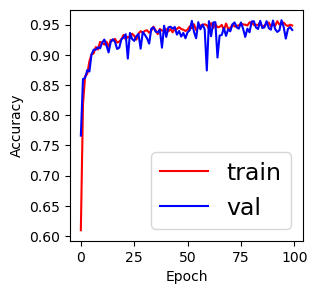

In [12]:
model = Sequential()
model.add(Dense(30, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given
model_trace = model.fit(X_train,y_train, verbose=0,epochs=100, validation_data=(X_test, y_test))
y_pred = model.predict(X_test)
evaluate(y_pred, y_test, model_trace)


## 4.3. HL(60 nodes, sigmoid)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 60)                1260      
                                                                 
 dense_9 (Dense)             (None, 3)                 183       
                                                                 
Total params: 1,443
Trainable params: 1,443
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 1ms/step
Accuracy: 0.95
Recall: 0.95


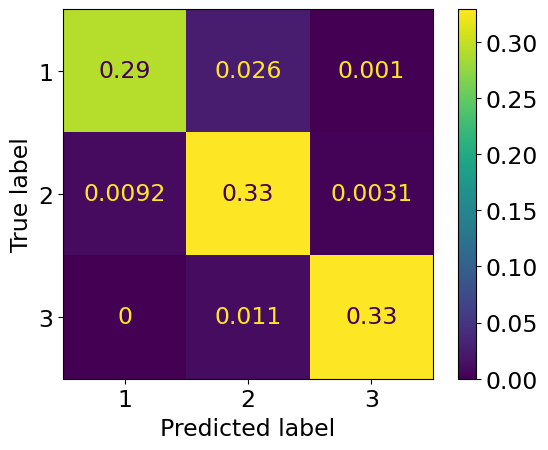

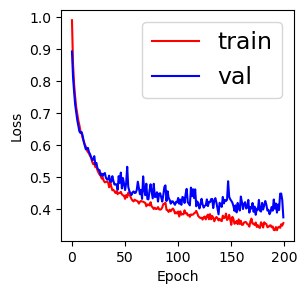

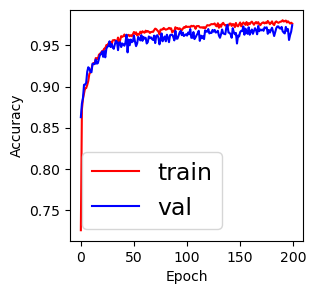

In [13]:
model = Sequential()
model.add(Dense(60, input_dim=X.shape[1], activation='sigmoid')) # Hidden 1
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given
model_trace = model.fit(X_train,y_train, verbose=0,epochs=200, validation_data=(X_test, y_test))
y_pred = model.predict(X_test)
evaluate(y_pred, y_test, model_trace)


## 4.4. HL(60 nodes, ReLu)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 60)                1260      
                                                                 
 dense_11 (Dense)            (None, 3)                 183       
                                                                 
Total params: 1,443
Trainable params: 1,443
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 949us/step
training time:17.07733917236328
test time:0.1132500171661377
Accuracy: 0.90
Recall: 0.92


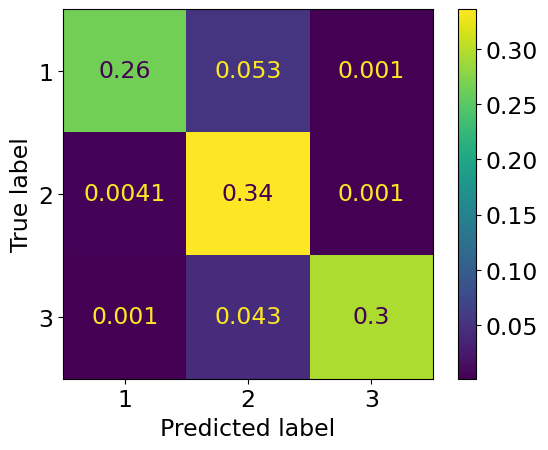

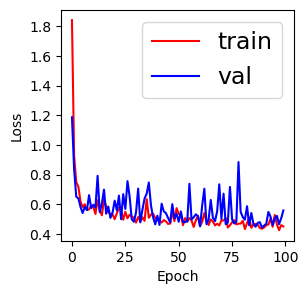

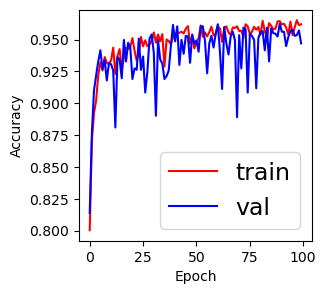

In [14]:
model = Sequential()
model.add(Dense(60, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

start_fit = time.time()
model_trace = model.fit(X_train,y_train, verbose=0,epochs=100, validation_data=(X_test, y_test))
end_fit = time.time()

start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()

time_fit = end_fit - start_fit;
time_pred = end_pred - start_pred; 

print(f'training time:{time_fit}')
print(f'test time:{time_pred}')
evaluate(y_pred, y_test, model_trace)

# 5 Increase layers

In this part, we test different number of hidden nodes to see how they affect the model's performance.

## 5.1. HL(15nodes, relu) x 2

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 15)                315       
                                                                 
 dense_13 (Dense)            (None, 15)                240       
                                                                 
 dense_14 (Dense)            (None, 3)                 48        
                                                                 
Total params: 603
Trainable params: 603
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 1ms/step
training time:18.411808013916016
test time:0.1381378173828125
Accuracy: 0.91
Recall: 0.92


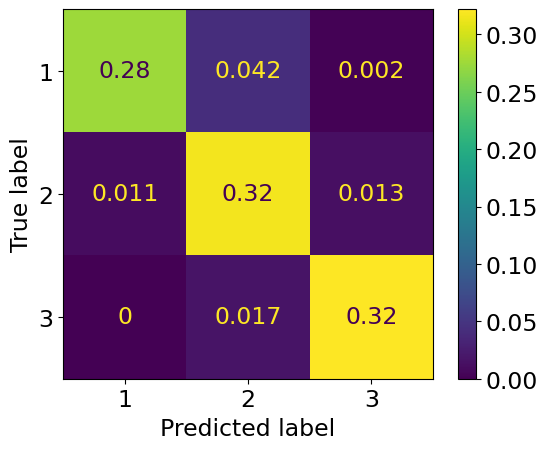

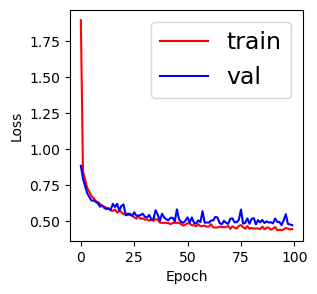

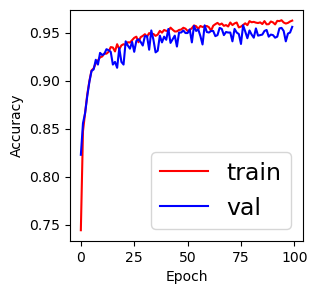

In [15]:
model = Sequential()
model.add(Dense(15, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dense(15, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

start_fit = time.time()
model_trace = model.fit(X_train,y_train, verbose=0,epochs=100, validation_data=(X_test, y_test))
end_fit = time.time()

start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()

time_fit = end_fit - start_fit;
time_pred = end_pred - start_pred; 

print(f'training time:{time_fit}')
print(f'test time:{time_pred}')
evaluate(y_pred, y_test, model_trace)



## 5.2. HL(15nodes, relu)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 15)                315       
                                                                 
 dense_16 (Dense)            (None, 3)                 48        
                                                                 
Total params: 363
Trainable params: 363
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 1ms/step
training time:17.688902854919434
test time:0.11308407783508301
Accuracy: 0.87
Recall: 0.88


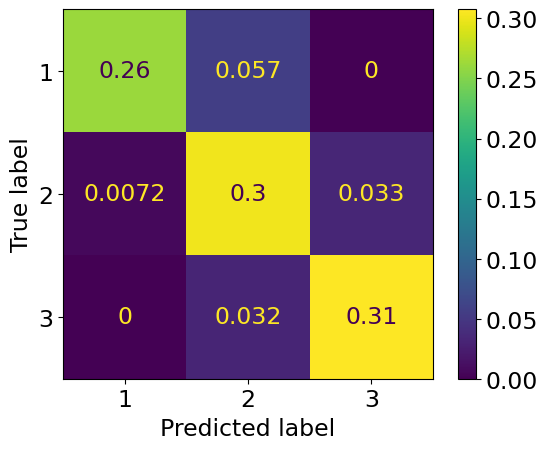

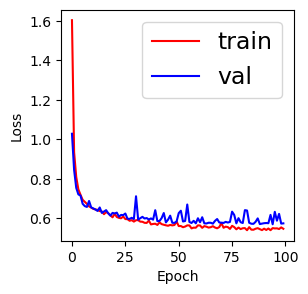

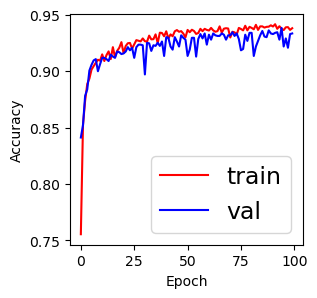

In [16]:
model = Sequential()
model.add(Dense(15, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

start_fit = time.time()
model_trace = model.fit(X_train,y_train, verbose=0,epochs=100, validation_data=(X_test, y_test))
end_fit = time.time()

start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()

time_fit = end_fit - start_fit;
time_pred = end_pred - start_pred; 

print(f'training time:{time_fit}')
print(f'test time:{time_pred}')
evaluate(y_pred, y_test, model_trace)


## 5.2. HL(15nodes, relu) x 4

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 15)                315       
                                                                 
 dense_18 (Dense)            (None, 15)                240       
                                                                 
 dense_19 (Dense)            (None, 15)                240       
                                                                 
 dense_20 (Dense)            (None, 15)                240       
                                                                 
 dense_21 (Dense)            (None, 3)                 48        
                                                                 
Total params: 1,083
Trainable params: 1,083
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 1ms/step

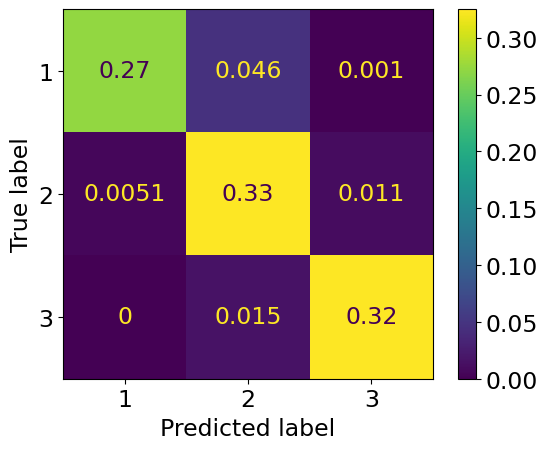

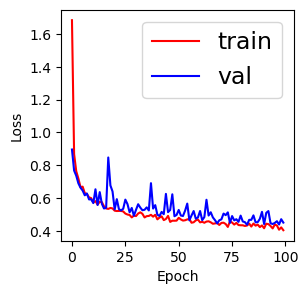

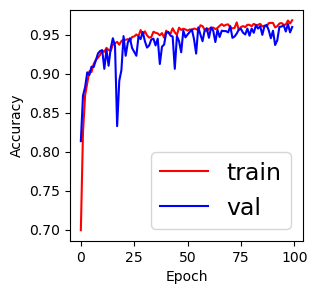

In [17]:
model = Sequential()
model.add(Dense(15, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dense(15, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

start_fit = time.time()
model_trace = model.fit(X_train,y_train, verbose=0,epochs=100, validation_data=(X_test, y_test))
end_fit = time.time()

start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()

time_fit = end_fit - start_fit;
time_pred = end_pred - start_pred; 

print(f'training time:{time_fit}')
print(f'test time:{time_pred}')
evaluate(y_pred, y_test, model_trace)

## 5.4. HL(30/15 nodes, relu) x 2

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 30)                630       
                                                                 
 dense_23 (Dense)            (None, 15)                465       
                                                                 
 dense_24 (Dense)            (None, 3)                 48        
                                                                 
Total params: 1,143
Trainable params: 1,143
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 1ms/step
training time:17.586755990982056
test time:0.13271403312683105
Accuracy: 0.94
Recall: 0.94


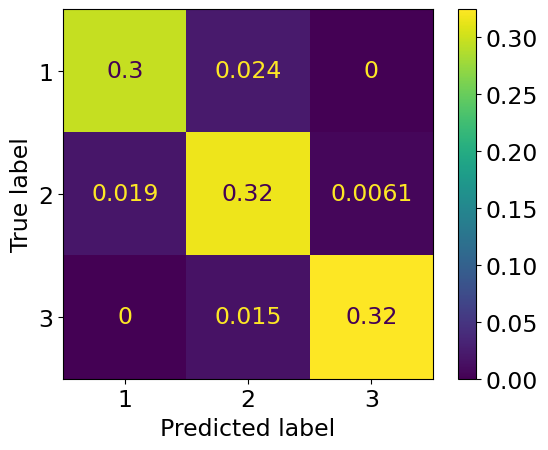

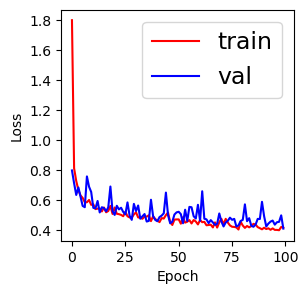

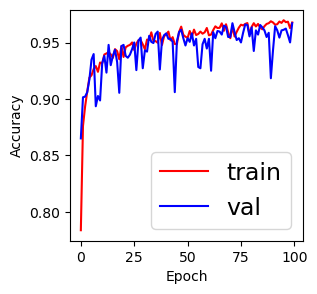

In [18]:
model = Sequential()
model.add(Dense(30, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dense(15, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

start_fit = time.time()
model_trace = model.fit(X_train,y_train, verbose=0,epochs=100, validation_data=(X_test, y_test))
end_fit = time.time()

start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()

time_fit = end_fit - start_fit;
time_pred = end_pred - start_pred; 

print(f'training time:{time_fit}')
print(f'test time:{time_pred}')
evaluate(y_pred, y_test, model_trace)


## 5.5. HL(60/50/40/30 nodes, relu) x 4 

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 60)                1260      
                                                                 
 dense_26 (Dense)            (None, 50)                3050      
                                                                 
 dense_27 (Dense)            (None, 40)                2040      
                                                                 
 dense_28 (Dense)            (None, 30)                1230      
                                                                 
 dense_29 (Dense)            (None, 3)                 93        
                                                                 
Total params: 7,673
Trainable params: 7,673
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 1ms/ste

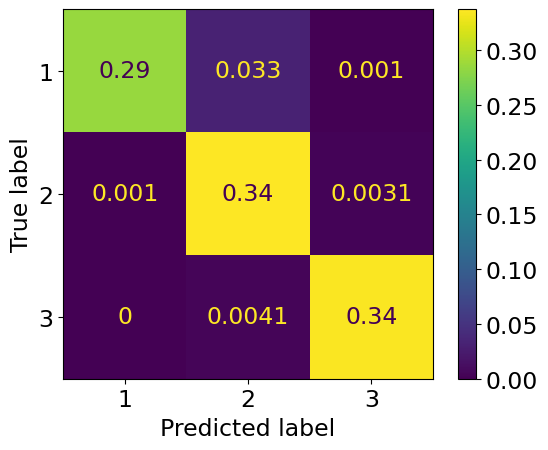

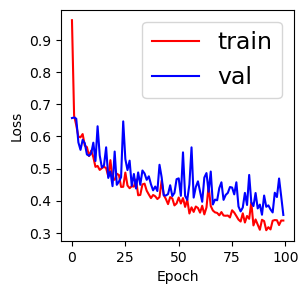

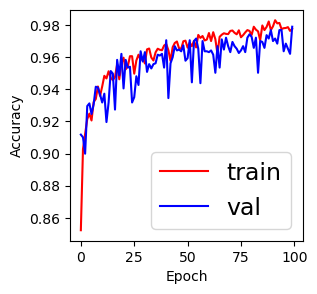

In [19]:
model = Sequential()
model.add(Dense(60, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dense(50, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

start_fit = time.time()
model_trace = model.fit(X_train,y_train, verbose=0,epochs=100, validation_data=(X_test, y_test))
end_fit = time.time()

start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()

time_fit = end_fit - start_fit;
time_pred = end_pred - start_pred; 

print(f'training time:{time_fit}')
print(f'test time:{time_pred}')
evaluate(y_pred, y_test, model_trace)

## 5.6. HL(100/100/100/100 nodes, relu) x 4

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 100)               2100      
                                                                 
 dense_31 (Dense)            (None, 100)               10100     
                                                                 
 dense_32 (Dense)            (None, 100)               10100     
                                                                 
 dense_33 (Dense)            (None, 100)               10100     
                                                                 
 dense_34 (Dense)            (None, 3)                 303       
                                                                 
Total params: 32,703
Trainable params: 32,703
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 1ms/s

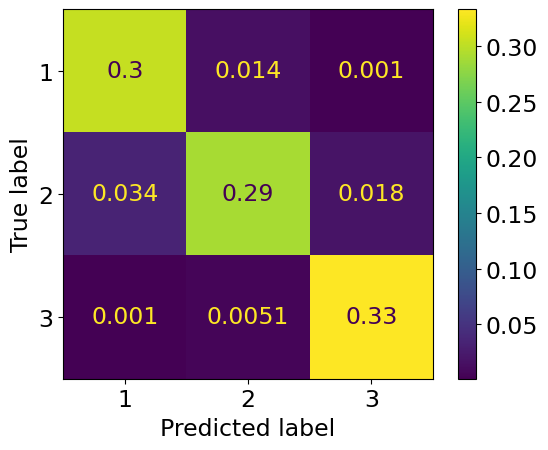

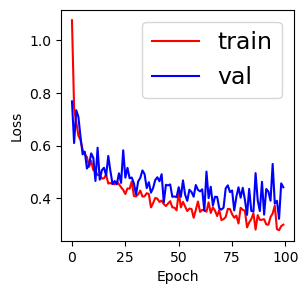

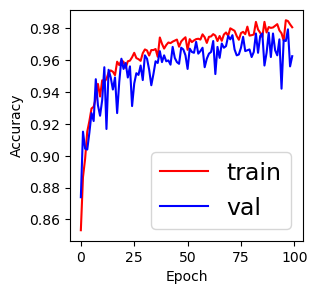

In [20]:
model = Sequential()
model.add(Dense(100, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

start_fit = time.time()
model_trace = model.fit(X_train,y_train, verbose=0,epochs=100, validation_data=(X_test, y_test))
end_fit = time.time()

start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()

time_fit = end_fit - start_fit;
time_pred = end_pred - start_pred; 

print(f'training time:{time_fit}')
print(f'test time:{time_pred}')
evaluate(y_pred, y_test, model_trace)

## 5.7. HL(200/200/200/200 nodes, relu) x 4

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_35 (Dense)            (None, 200)               4200      
                                                                 
 dense_36 (Dense)            (None, 200)               40200     
                                                                 
 dense_37 (Dense)            (None, 200)               40200     
                                                                 
 dense_38 (Dense)            (None, 200)               40200     
                                                                 
 dense_39 (Dense)            (None, 3)                 603       
                                                                 
Total params: 125,403
Trainable params: 125,403
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 2ms

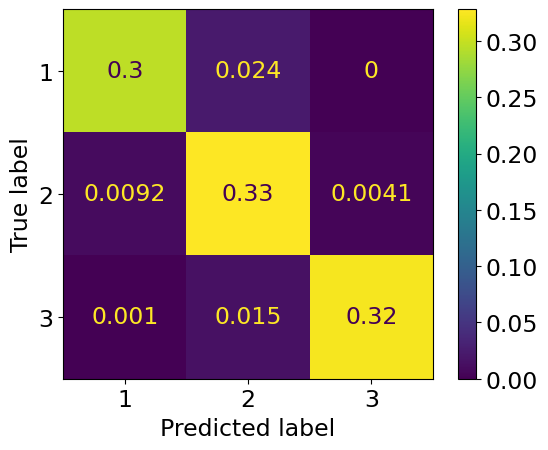

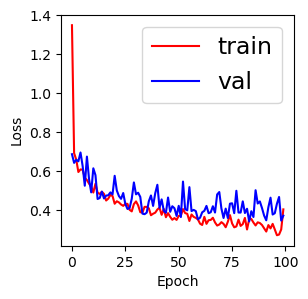

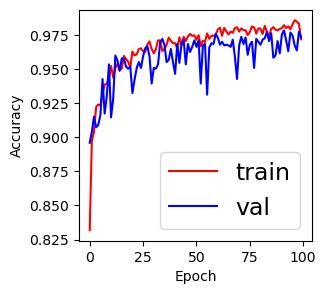

In [21]:
model = Sequential()
model.add(Dense(200, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

start_fit = time.time()
model_trace = model.fit(X_train,y_train, verbose=0,epochs=100, validation_data=(X_test, y_test))
end_fit = time.time()

start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()

time_fit = end_fit - start_fit;
time_pred = end_pred - start_pred; 

print(f'training time:{time_fit}')
print(f'test time:{time_pred}')
evaluate(y_pred, y_test, model_trace)

## 5.8. HL(100/100/100/100 nodes, relu, epoch=200) x 4

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 100)               2100      
                                                                 
 dense_41 (Dense)            (None, 100)               10100     
                                                                 
 dense_42 (Dense)            (None, 100)               10100     
                                                                 
 dense_43 (Dense)            (None, 100)               10100     
                                                                 
 dense_44 (Dense)            (None, 3)                 303       
                                                                 
Total params: 32,703
Trainable params: 32,703
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 1ms/s

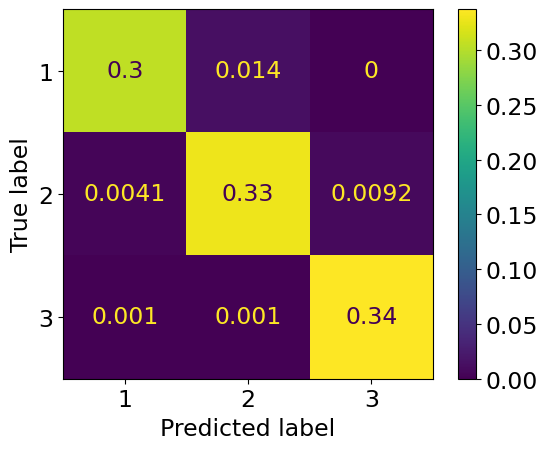

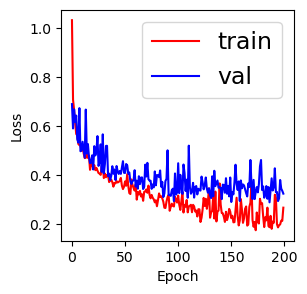

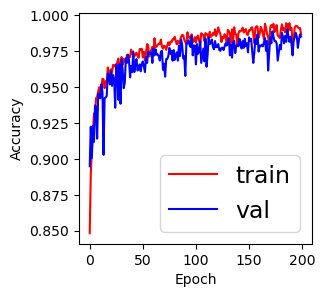

In [22]:
model = Sequential()
model.add(Dense(100, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

start_fit = time.time()
model_trace = model.fit(X_train,y_train, verbose=0,epochs=200, validation_data=(X_test, y_test))
end_fit = time.time()

start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()

time_fit = end_fit - start_fit;
time_pred = end_pred - start_pred; 

print(f'training time:{time_fit}')
print(f'test time:{time_pred}')
evaluate(y_pred, y_test, model_trace)

## 5.9. HL(100/100/100/100 nodes, relu, epoch=150) x 4 - BEST ONE

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 100)               2100      
                                                                 
 dense_46 (Dense)            (None, 100)               10100     
                                                                 
 dense_47 (Dense)            (None, 100)               10100     
                                                                 
 dense_48 (Dense)            (None, 100)               10100     
                                                                 
 dense_49 (Dense)            (None, 3)                 303       
                                                                 
Total params: 32,703
Trainable params: 32,703
Non-trainable params: 0
_________________________________________________________________
31/31 [==============================] - 0s 2ms/s

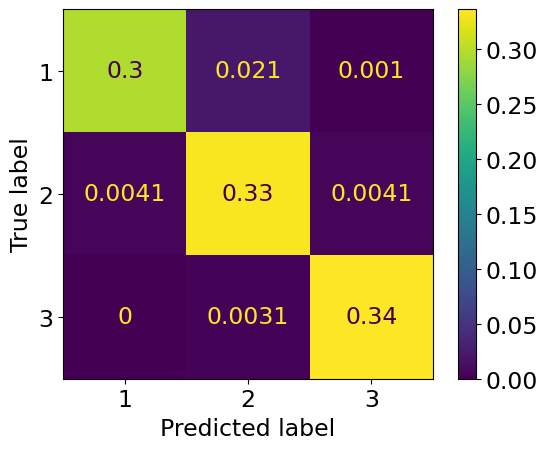

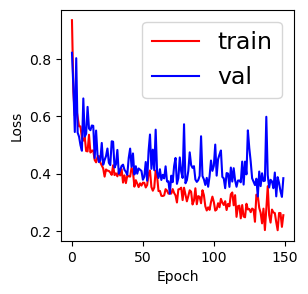

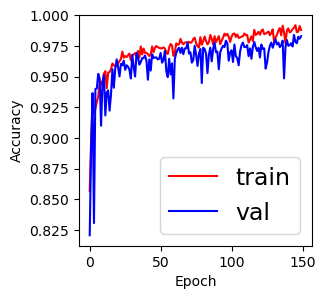

In [23]:
model = Sequential()
model.add(Dense(100, input_dim=X.shape[1], activation='relu')) # Hidden 1
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax')) # Output
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() #note, only works if input shape specified, or Input layer given

start_fit = time.time()
model_trace = model.fit(X_train,y_train, verbose=0,epochs=150, validation_data=(X_test, y_test))
end_fit = time.time()

start_pred = time.time()
y_pred = model.predict(X_test)
end_pred = time.time()

time_fit = end_fit - start_fit;
time_pred = end_pred - start_pred; 

print(f'training time:{time_fit}')
print(f'test time:{time_pred}')
evaluate(y_pred, y_test, model_trace)